In [1]:
import os, sys
import numpy as np
import re
import pandas as pd

import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.style.use('ggplot')

caffe_root = '/home/ashu/Desktop/Thesis Work/Classifier/caffe/'
print os.getcwd()
sys.path.insert(0, caffe_root + 'python')
import caffe

import argparse

from caffe.proto import caffe_pb2
import google.protobuf as pb2
import google.protobuf.text_format

import lmdb
from collections import defaultdict
from sklearn.metrics import confusion_matrix

/home/ashu/Desktop/Thesis Work/Classifier/caffe/models/script


In [7]:
def compute_average_prec(y_true, y_pred):
    
    npos = np.sum(np.asarray(y_true))
    
    # applying logical and at each binary values
    tp = np.logical_and(y_pred == 1, y_true == 1)
    fp = np.logical_and(y_pred == 1, y_true == 0)
    
    
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    # Correct Method
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
         mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [8]:
caffe.set_mode_gpu()
    
object_name = 'laptop'
# Modify the paths given below
deploy_prototxt_file_path = caffe_root + 'models/gt_classifier/' + object_name +  \
                            '/test.prototxt' # Network definition file
test_lmdb_path = caffe_root + 'models/gt_classifier/' + object_name +  '/' + object_name + \
                            '_val_lmdb_224/' # Test LMDB database path
mean_file_binaryproto = caffe_root + 'models/gt_classifier/' + object_name +  '/' + object_name + \
                            '_val_224_mean.binaryproto' # Mean image file
    
iteration = range(30000, 31000, 1000)
result_open = []
result_close = []

# loop through each model and check the performance
for val in iteration:
    # load each caffe model
    caffe_model_file_path = caffe_root + 'models/gt_classifier/' + object_name +  '/trained_model/' + \
                            '/gt_' + object_name + '_' +  str(max(iteration)) + \
                            '_iter_15000'  + '.caffemodel' 
    #print caffe_model_file_path
    
    # Extract mean from the mean image file
    mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
    f = open(mean_file_binaryproto, 'rb')
    mean_blobproto_new.ParseFromString(f.read())
    mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
    f.close()
        
    # CNN reconstruction and loading the trained weights
    net = caffe.Net(deploy_prototxt_file_path, caffe_model_file_path, caffe.TEST)
        
    lmdb_env = lmdb.open(test_lmdb_path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
      
    # list to store labela, plabels and pscorees for each image
    labels_open = []
    plabels_open = []
    labels_close = []
    plabels_close = []
    #pscores = []
    pscores_open = []
    pscores_closed = []
        
    for key, value in lmdb_cursor:
        # extract label
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
            
        # predict label
        image = caffe.io.datum_to_array(datum)
        image = image.astype(np.uint8)
        out = net.forward_all(data=np.asarray([image]) - mean_image)
        plabel = int(out['prob'][0].argmax(axis=0))
        #pscores.append(float(out['prob'][0].max(axis=0))) 
            
        # add label and predicted label, pscore on appropiate list y converting in 1hot format
        if label == 1: # closed object
            labels_close.append(1)  # actual label in 1 hot
            labels_open.append(0)
            pscores_closed.append(float(out['prob'][0].max(axis=0)))
            if plabel == 1: # when predicted correctly
                plabels_close.append(1)
                plabels_open.append(0)
            else: # when predicted wrong
                plabels_close.append(0)
                plabels_open.append(1)
        else:   # open object case
            labels_close.append(0)  # actual label in 1 hot
            labels_open.append(1)
            pscores_open.append(float(out['prob'][0].max(axis=0)))
            if plabel == 0: # when predicted correctly
                plabels_close.append(0)
                plabels_open.append(1)
            else: # when predicted wrong
                plabels_close.append(1)
                plabels_open.append(0)
        
    #uncomment for sanity check 
          
    tn, fp, fn, tp = confusion_matrix(labels_close, plabels_close).ravel()
    print 'tn, fp, fn, tp : ', tn, fp, fn, tp    
    print ' #Open : ', np.sum(np.asarray(labels_open)), ' #Closed : ', np.sum(np.asarray(labels_close))
    
    
    #convert list to numpy array
    labels_open = np.array(labels_open)
    plabels_open = np.array(plabels_open)
    
    labels_close = np.array(labels_close)
    plabels_close = np.array(plabels_close)
    
    pscores_open = np.array(pscores_open)
    pscores_closed = np.array(pscores_closed)
    
    #get sorted indices of open and close acc to score
    sorted_ind_open = np.argsort(-pscores_open)
    sorted_ind_closed = np.argsort(-pscores_closed)
    
    
    
    # sort ind acc to score and compute avg precision
    ap_open = compute_average_prec(labels_open[sorted_ind_open], plabels_open[sorted_ind_open])
    ap_close = compute_average_prec(labels_close[sorted_ind_closed], plabels_close[sorted_ind_closed])
        
    print '#Iteration: ', val, ' AP open : ' + object_name + ' : ', ap_open
    print '#Iteration: ', val, ' AP closed : ' + object_name + ' : ', ap_close
        
    result_open.append(ap_open)
    result_close.append(ap_close)
        
data = { '#Iteration' : iteration, 'AP_Open': result_open, 'AP_Close': result_close}
df = pd.DataFrame(data, columns = ['#Iteration', 'AP_Open', 'AP_Close'])
df['mAP'] = df[['AP_Open', 'AP_Close']].mean(axis=1)

# general for any number of labels
'''
count = 0
correct = 0
matrix = defaultdict(int) # (real,pred) -> int
labels_set = set()
    
lmdb_env = lmdb.open(test_lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
    
    
for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    label = int(datum.label)
    image = caffe.io.datum_to_array(datum)
    image = image.astype(np.uint8)
    out = net.forward_all(data=np.asarray([image]) - mean_image)
    plabel = int(out['prob'][0].argmax(axis=0))
    count += 1
    iscorrect = label == plabel
    correct += (1 if iscorrect else 0)
    matrix[(label, plabel)] += 1
    labels_set.update([label, plabel])
    
    if not iscorrect:
        print("\rError: key = %s, expected %i but predicted %i" % (key, label, plabel))
        sys.stdout.write("\rAccuracy: %.1f%%" % (100.*correct/count))
        sys.stdout.flush()
    
print("\n" + str(correct) + " out of " + str(count) + " were classified correctly")
print ""
print "Confusion matrix:"
print "(r , p) | count"
for l in labels_set:
    for pl in labels_set:
        print "(%i , %i) | %i" % (l, pl, matrix[(l,pl)])
            
'''        


tn, fp, fn, tp :  0 0 41 136
 #Open :  1625  #Closed :  177
new tp, fp [   1    2    3 ..., 1590 1591 1591] [0 0 0 ..., 0 0 0]
new tp, fp [  1   2   3   3   4   4   5   5   6   7   8   9  10  11  12  13  13  14
  15  16  17  18  19  19  20  21  22  23  24  25  26  26  27  28  29  30
  30  31  32  33  33  33  34  35  36  37  38  38  39  39  40  41  41  41
  42  43  44  45  46  47  48  49  49  50  51  51  52  53  54  55  55  55
  56  57  58  59  60  61  62  62  63  63  64  65  66  67  68  69  70  71
  72  73  74  74  75  75  76  76  77  78  79  80  81  82  82  82  83  83
  83  84  84  85  86  86  87  88  89  90  91  92  93  94  95  95  96  97
  98  98  99  99 100 101 102 103 104 105 105 106 107 108 108 109 110 111
 111 112 112 113 114 115 116 117 118 119 120 120 121 122 123 124 125 125
 126 126 127 128 129 130 131 132 132 132 133 134 135 136 136] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

'\ncount = 0\ncorrect = 0\nmatrix = defaultdict(int) # (real,pred) -> int\nlabels_set = set()\n    \nlmdb_env = lmdb.open(test_lmdb_path)\nlmdb_txn = lmdb_env.begin()\nlmdb_cursor = lmdb_txn.cursor()\n    \n    \nfor key, value in lmdb_cursor:\n    datum = caffe.proto.caffe_pb2.Datum()\n    datum.ParseFromString(value)\n    label = int(datum.label)\n    image = caffe.io.datum_to_array(datum)\n    image = image.astype(np.uint8)\n    out = net.forward_all(data=np.asarray([image]) - mean_image)\n    plabel = int(out[\'prob\'][0].argmax(axis=0))\n    count += 1\n    iscorrect = label == plabel\n    correct += (1 if iscorrect else 0)\n    matrix[(label, plabel)] += 1\n    labels_set.update([label, plabel])\n    \n    if not iscorrect:\n        print("\rError: key = %s, expected %i but predicted %i" % (key, label, plabel))\n        sys.stdout.write("\rAccuracy: %.1f%%" % (100.*correct/count))\n        sys.stdout.flush()\n    \nprint("\n" + str(correct) + " out of " + str(count) + " were clas

In [40]:
print df

    #Iteration   AP_Open  AP_Close       mAP
0         1000  0.975978  0.551382  0.763680
1         2000  0.976174  0.597118  0.786646
2         3000  0.971986  0.639840  0.805913
3         4000  0.973542  0.630895  0.802219
4         5000  0.974974  0.636604  0.805789
5         6000  0.979786  0.567856  0.773821
6         7000  0.969830  0.672092  0.820961
7         8000  0.976669  0.616867  0.796768
8         9000  0.981712  0.611750  0.796731
9        10000  0.975929  0.654051  0.814990
10       11000  0.983672  0.562209  0.772941
11       12000  0.976877  0.642961  0.809919
12       13000  0.976319  0.678716  0.827518
13       14000  0.977511  0.649602  0.813557
14       15000  0.975175  0.707635  0.841405
15       16000  0.981119  0.644328  0.812724
16       17000  0.975614  0.675513  0.825564
17       18000  0.982739  0.606932  0.794835
18       19000  0.975396  0.639288  0.807342
19       20000  0.971056  0.727024  0.849040
20       21000  0.977273  0.667905  0.822589
21       2

In [41]:
csv_file = caffe_root + 'models/gt_classifier/' + object_name + '/Results/gt_classifier_' \
            + object_name + '_' + str(max(iteration)) + '_new.csv'
df.to_csv(csv_file)

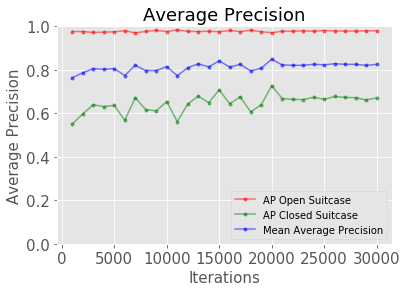

In [42]:
'''
Plot AP
'''
plot_path = csv_file[:-4] + '_result.png'
#path = caffe_root + 'models/gt_classifier/laptop/Results/Results_50000.csv'
df_plot = pd.read_csv(csv_file)
fig, ax1 = plt.subplots()

#Plotting training and test losses
AvgPrec_Open, = ax1.plot(df_plot['#Iteration'], df_plot['AP_Open'], color='red',  alpha=.5, marker='.')
AvgPrec_Close, = ax1.plot(df_plot['#Iteration'], df_plot['AP_Close'], alpha=.5, color='green', marker='.')
mAP, = ax1.plot(df_plot['#Iteration'], df_plot['mAP'], alpha=.5, color='blue', marker='.')
ax1.set_ylim(ymin=0, ymax=1)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Average Precision', fontsize=15)
ax1.tick_params(labelsize=15)

plt.legend([AvgPrec_Open, AvgPrec_Close, mAP], ['AP Open Suitcase', 'AP Closed Suitcase', 'Mean Average Precision'],  loc='lower right')
plt.title('Average Precision', fontsize=18)
#plt.show()
plt.savefig(plot_path)